In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def run_query(q):
    with sqlite3.connect("chinook.db") as conn:
        return pd.read_sql_query(q,conn)

def run_command(c):
    with sqlite3.connect("chinook.db") as conn:
        conn.isolation_level = None
        conn.execute(c)

def show_tables(q):
    return run_query(q)

In [3]:
q = '''SELECT name, type
        FROM sqlite_master
       WHERE type IN ("table", "view")'''
show_tables(q)

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [4]:
q3 = '''
SELECT genre, tracks_sold,
    CAST(tracks_sold as float)/(
        SELECT COUNT(invoice_line.track_id)
        FROM invoice_line
        INNER JOIN invoice ON invoice.invoice_id = invoice_line.invoice_id
        WHERE invoice.billing_country = "USA") percentage_sold
FROM (
    SELECT genre.name genre,invoice.billing_country country,COUNT(track.track_id) tracks_sold
    FROM genre
    INNER JOIN track ON track.genre_id = genre.genre_id
    INNER JOIN invoice_line ON invoice_line.track_id = track.track_id
    INNER JOIN invoice ON invoice.invoice_id = invoice_line.invoice_id
    WHERE invoice.billing_country = "USA"
    GROUP BY genre)
ORDER BY tracks_sold desc
LIMIT 10
    '''
run_query(q3)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


In [5]:
genre_sales_usa = run_query(q3)
genre_sales_usa.set_index("genre", inplace=True, drop=True)
genre_sales_usa

,tracks_sold,percentage_sold
genre,,
Rock,561,0.533777
Alternative & Punk,130,0.123692
Metal,124,0.117983
R&B/Soul,53,0.050428
Blues,36,0.034253
Alternative,35,0.033302
Latin,22,0.020932
Pop,22,0.020932
Hip Hop/Rap,20,0.019029


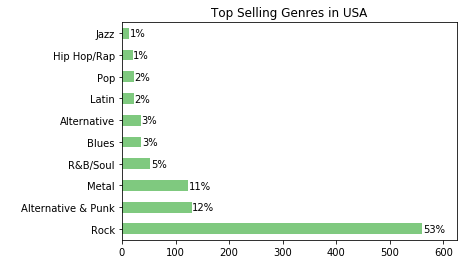

In [7]:
genre_sales_usa["tracks_sold"].plot(kind="barh",title="Top Selling Genres in USA", xlim=(0,625), colormap=plt.cm.Accent)
plt.ylabel(" ")
for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "tracks_sold"]
    label = (genre_sales_usa.loc[label, "percentage_sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 1, i - 0.15))
plt.show()

In [8]:
employee_sales_performance = '''
WITH customer_support_rep_sales AS
    (
    SELECT
        c.support_rep_id support_rep_id,
        SUM(ic.total) total
    FROM customer c
    INNER JOIN
        (SELECT
            customer_id,
            SUM(total) total
        FROM invoice
        GROUP BY customer_id)
        ic ON ic.customer_id = c.customer_id
    GROUP BY support_rep_id
    )

SELECT
    e.first_name||" "||e.last_name employee,
    e.hire_date,
    csrs.total
FROM employee e
INNER JOIN customer_support_rep_sales csrs
    ON csrs.support_rep_id = e.employee_id'''

employee_sales = run_query(employee_sales_performance)
employee_sales.set_index("employee", inplace=True, drop=True)
employee_sales

,hire_date,total
employee,,
Jane Peacock,2017-04-01 00:00:00,1731.51
Margaret Park,2017-05-03 00:00:00,1584.00
Steve Johnson,2017-10-17 00:00:00,1393.92


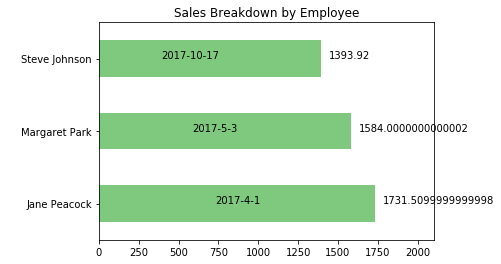

In [9]:
employee_sales["total"].plot(kind="barh", colormap=plt.cm.Accent)
plt.ylabel(" ")
plt.title("Sales Breakdown by Employee")
plt.xlim(0, 2100)
for i, label in enumerate(list(employee_sales.index)):
    score = employee_sales.loc[label, "total"]
    datetime = pd.to_datetime(employee_sales.loc[label, "hire_date"])
    hire_date = str(datetime.year)+"-"+str(datetime.month)+"-"+str(datetime.day)
    plt.annotate(str(score), (score + 50,i))
    plt.annotate(hire_date, (score -1000,i))
plt.show()

In [10]:
sales_country_OLD= '''
WITH
    sales_per_country AS
    (
    SELECT
        country,
        COUNT(country) customers,
        SUM(total) Sales,
        CAST(SUM(total) AS float)/CAST(COUNT(country) AS float) Sales_customer,
        SUM(orders) Orders,
        CAST(SUM(total) AS float)/CAST(SUM(orders) AS float) avg_order_value
    FROM
        (
        SELECT
            c.country country,
            it.orders orders,
            it.total total
        FROM customer c
        INNER JOIN
            (
            SELECT
                customer_id,
                COUNT(total) orders,
                SUM(total) total
            FROM invoice
            GROUP BY customer_id
            ) it
            ON it.customer_id = c.customer_id
        )
    GROUP BY country
    ORDER BY Sales desc
    ),

    others AS
    (
    SELECT
        o.group_country group_country,
        SUM(o.customers) customers,
        SUM(o.Sales) Sales,
        SUM(o.Orders) Orders,
        CAST(SUM(o.Sales) AS float)/CAST(SUM(o.customers) AS float) Sales_customer,
        CAST(SUM(o.Sales) AS float)/CAST(SUM(o.Orders) AS float) avg_order_value
    FROM
        (SELECT
            spc.*,
            CASE
                WHEN spc.customers = 1 THEN "Others"
                ELSE spc.country
            END AS group_country
        FROM sales_per_country spc) o
    GROUP BY group_country
    ),

    othersrev AS
    (
    SELECT
        o.*,
        CASE
            WHEN o.group_country = "Others" THEN 0
            ELSE 1
        END AS sort
    FROM others o
    ORDER BY o.Sales desc
    )

SELECT
    group_country Country,
    customers Customers,
    Sales,
    Orders,
    avg_order_value ASPO,
    Sales_customer SPC
FROM othersrev
ORDER BY sort DESC
'''
run_query(sales_country_OLD)

,Country,Customers,Sales,Orders,ASPO,SPC
0,USA,13,1040.49,131,7.942672,80.037692
1,Canada,8,535.59,76,7.047237,66.948750
2,Brazil,5,427.68,61,7.011148,85.536000
3,France,5,389.07,50,7.781400,77.814000
4,Germany,4,334.62,41,8.161463,83.655000
5,Czech Republic,2,273.24,30,9.108000,136.620000
6,United Kingdom,3,245.52,28,8.768571,81.840000
7,Portugal,2,185.13,29,6.383793,92.565000
8,India,2,183.15,21,8.721429,91.575000
9,Others,15,1094.94,147,7.448571,72.996000


In [11]:
test = '''
WITH country_sales AS
(SELECT
    CASE
        WHEN COUNT(customerid) = 1 THEN "Others"
        ELSE country
    END AS country,
    CASE
        WHEN COUNT(customerid) = 1 THEN 0
        ELSE 1
    END AS sort,
    SUM(Orders) Orders,
    SUM(Sales) Sales,
    COUNT(customerid) Customers
FROM
    (SELECT
        c.country country, c.customer_id customerid,
        COUNT(i.invoice_id) Orders, SUM(i.total) Sales
    FROM customer c
    INNER JOIN invoice i ON i.customer_id = c.customer_id
    GROUP BY customerid)
GROUP BY country
ORDER BY Sales desc)

SELECT
    country, SUM(Orders) Orders, SUM(Sales) Sales, SUM(Customers) Customers,
    CAST(SUM(Sales) AS float)/CAST(SUM(Orders) AS float) ASPO,
    CAST(SUM(Sales) AS float)/CAST(SUM(Customers) AS Customers) SPC
FROM country_sales
GROUP BY country
ORDER BY sort DESC, Sales DESC '''
sales_country_df = run_query(test)
sales_country_df

,country,Orders,Sales,Customers,ASPO,SPC
0,USA,131,1040.49,13,7.942672,80.037692
1,Canada,76,535.59,8,7.047237,66.948750
2,Brazil,61,427.68,5,7.011148,85.536000
3,France,50,389.07,5,7.781400,77.814000
4,Germany,41,334.62,4,8.161463,83.655000
5,Czech Republic,30,273.24,2,9.108000,136.620000
6,United Kingdom,28,245.52,3,8.768571,81.840000
7,Portugal,29,185.13,2,6.383793,92.565000
8,India,21,183.15,2,8.721429,91.575000
9,Others,147,1094.94,15,7.448571,72.996000


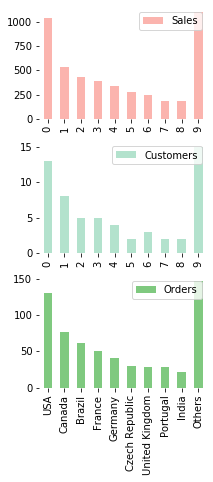

In [13]:
fig = plt.figure(figsize=(3,7))
columns = ["Sales", "Customers", "Orders"]
colors = [plt.cm.Pastel1, plt.cm.Pastel2, plt.cm.Accent]
for i in range(3):
    ax = fig.add_subplot(3,1,i+1)
    ax = sales_country_df[columns[i]].plot(kind="bar",colormap=colors[i])
    if i==2:
        ax.set_xticklabels(sales_country_df["country"])
    else:
        ax.tick_params(labelbottom="off")
    for key, spine in ax.spines.items():
        spine.set_visible(False)
    ax.tick_params(bottom="off", left="off")
    ax.legend(loc="upper right")
plt.show()

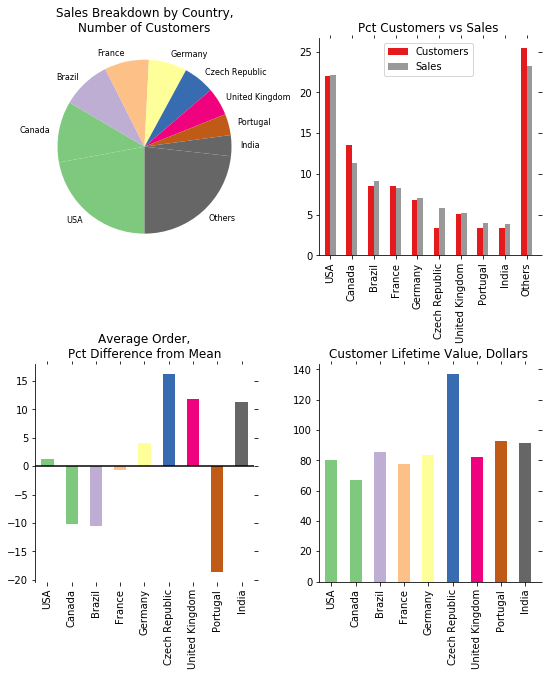

In [15]:
country_metrics = sales_country_df.set_index("country",drop=True)
country_metrics
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)

# top left
sales_breakdown = country_metrics["Sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0})

# top right
cvd_cols = ["Customers","Sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = country_metrics["ASPO"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Others", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["SPC"].copy()
ltv.index.name = ''
ltv.drop("Others",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)
plt.show()

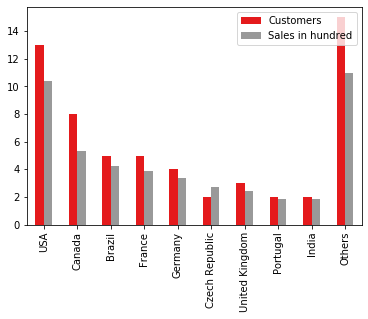

In [16]:
sales_country_df["Sales in hundred"] = sales_country_df["Sales"]/100
columns = ["Customers", "Sales in hundred"]
ax = sales_country_df[columns].plot(kind="bar",colormap=plt.cm.Set1)
ax.set_xticklabels(sales_country_df["country"])
ax.tick_params(bottom="off", left="off")
ax.legend(loc="upper right")
plt.show()

In [17]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT)/(SELECT COUNT(*) FROM invoice) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     )

                  EXCEPT

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     )
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase; '''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


In [18]:
rev_yes_no = '''
WITH invoice_first_track AS
(SELECT
    invoice_id,
    MIN(track_id) first_track_id
FROM invoice_line
GROUP BY invoice_id),
invoice_yes_no AS
(SELECT
    ift.*,
    CASE
        WHEN
        (
            SELECT t.track_id from track t
            WHERE t.album_id = (SELECT t2.album_id FROM track t2
                                WHERE t2.track_id = ift.first_track_id)
            EXCEPT
            SELECT il.track_id FROM invoice_line il
            WHERE il.invoice_id = ift.invoice_id) IS NULL
        AND
        (   SELECT il.track_id FROM invoice_line il
            WHERE il.invoice_id = ift.invoice_id
            EXCEPT
            SELECT t.track_id from track t
            WHERE t.album_id = (SELECT t2.album_id FROM track t2
                                WHERE t2.track_id = ift.first_track_id)) IS NULL
        THEN "yes"
        ELSE "no"
    END AS "yes_no"
FROM invoice_first_track ift)

SELECT
    yes_no Album_purchase,
    COUNT(invoice_id)
FROM invoice_yes_no
GROUP BY yes_no'''
run_query(rev_yes_no)

,Album_purchase,COUNT(invoice_id)
0,no,500
1,yes,114
